# Credit Risk Assessment: SHAP Analysis

---

In [3]:
from aura.utils.pathing import models, reports, root
import joblib
import shap 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")
stamp=date.today().isoformat()
data = Path("../data/processed")

### SHAP Analysis

SHAP artefacts saved


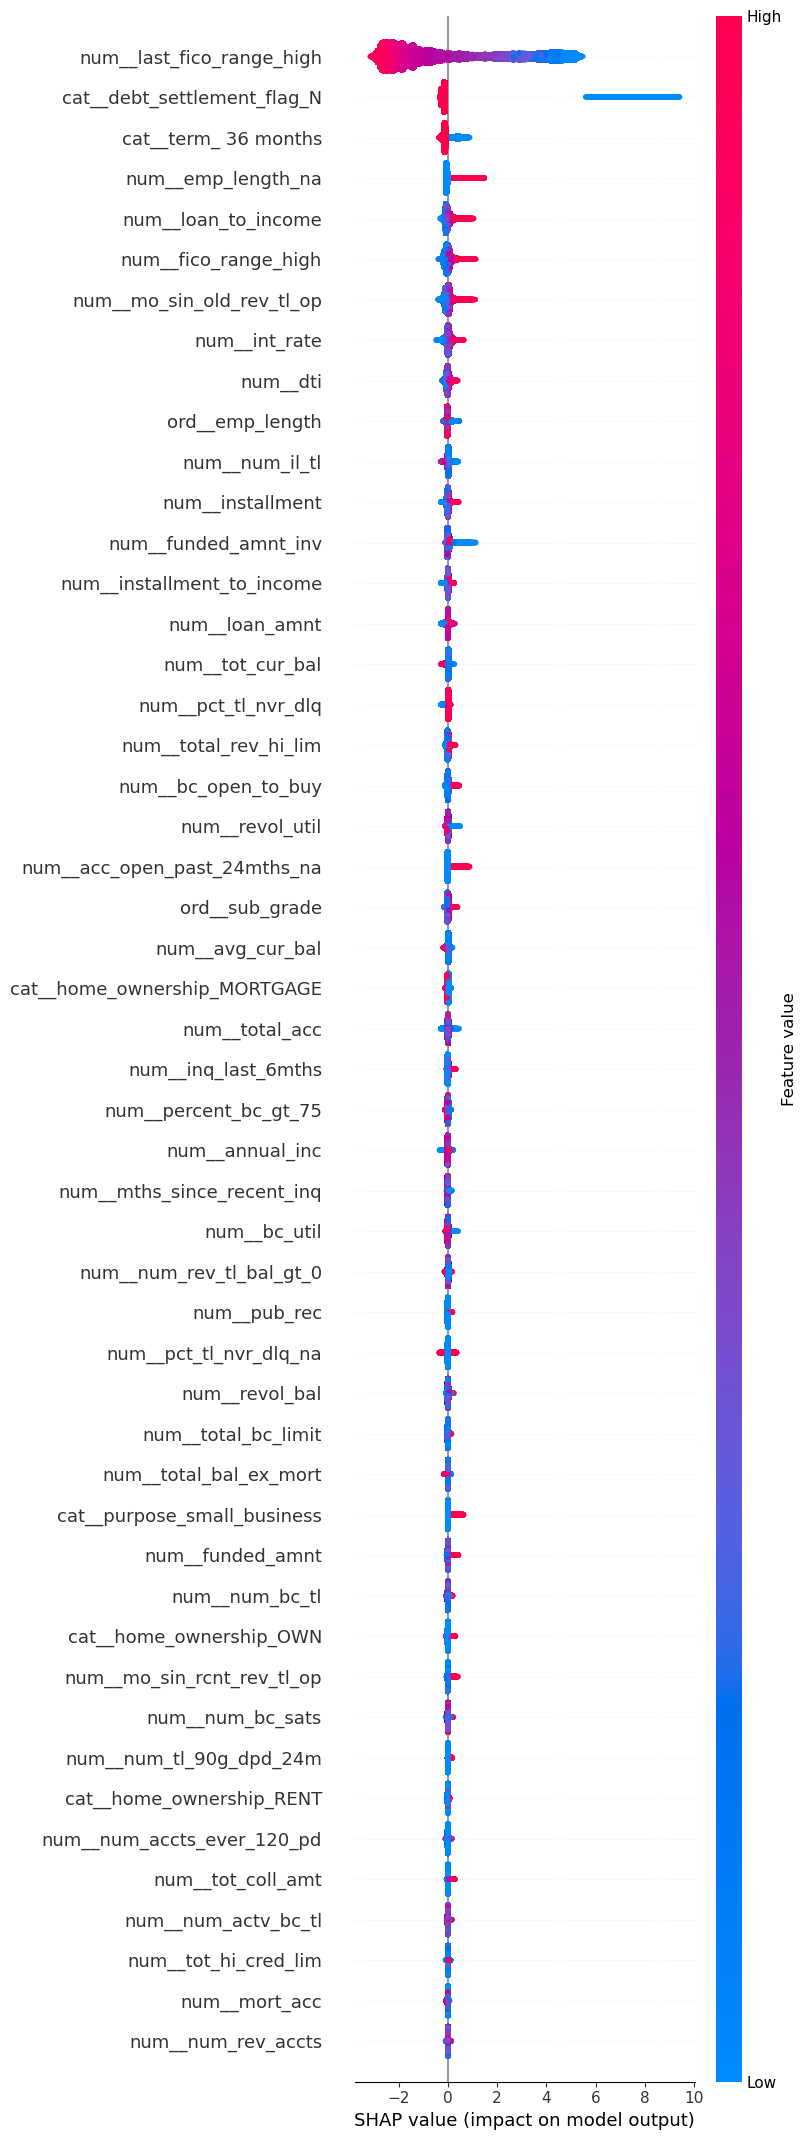

In [4]:
shap_idx_path = models/"shap_topidx_v1.joblib"
if shap_idx_path.exists():
    print("Using cached SHAP artefacts"); top_idx = joblib.load(shap_idx_path)
else:
    gbm = joblib.load(models/"lgbm_v1.joblib")
    Xtrain= sparse.load_npz(data/"X_train.npz").toarray()
    pre= joblib.load(data/"preprocessor.joblib")
    feats = pre.get_feature_names_out()

    explainer = shap.TreeExplainer(gbm)
    shap_vals = explainer.shap_values(Xtrain, check_additivity=False)
    if isinstance(shap_vals,list): shap_vals=shap_vals[0]

    top_idx = np.argsort(np.abs(shap_vals).mean(0))[::-1][:50]
    joblib.dump(top_idx, shap_idx_path)
    np.savez_compressed(models/"shap_vals_train.npz", shap_vals=shap_vals.astype("float32"))

    shap.summary_plot(shap_vals, Xtrain, feature_names=feats,
                      max_display=50, show=False)
    plt.savefig(reports/"figs/shap_summary_lightgbm.png", dpi=300, bbox_inches="tight")
    pd.Series(np.abs(shap_vals).mean(0)[top_idx], index=feats[top_idx])\
      .to_csv(reports/"top_drivers.csv")

    print("SHAP artefacts saved")